In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pickle
import time
import os
tqdm.pandas()
sns.set_style("whitegrid")
%config InlineBackend.figure_formats = ['svg']

# Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

### Utiles

In [60]:
# Le modèle prend x et donne l'ID de la classe LABEL
# Dans la dataset, on a appliqué du OneHotEncoding par défaut
# Certains algos comme GaussianNB ont besoin d'avoir
# juste l'ID comme target et non pas un vecteur OneHot
# Comme les autres algo sont compatibles, on va donc
# y_train [OneHot] -> to_label_category [Id categorie]
# Et à la prédiction
# y_pred [Id categorie] -> to_one_hot [OneHot]
# pour le comparer au y_test [OneHot] de la dataset

def to_label_category(y_set):
    return LABEL_COLUMN_LIST.get_indexer(y_set.idxmax(axis=1))

def to_one_hot(y_set):
    vect = np.zeros((len(y_set), len(LABEL_COLUMN_LIST)))
    vect[np.arange(len(y_set)), y_set] = 1
    return vect

In [61]:
def draw_confusion_matrix(model_name, y_true, y_pred):
    id_label_column = [i for i in range(len(LABEL_COLUMN_LIST))]
    cf_matrix = confusion_matrix(y_pred.argmax(axis=1), y_true.values.argmax(axis=1), labels=id_label_column)
    cf_matrix_df = pd.DataFrame(cf_matrix, 
        index=LABEL_COLUMN_LIST, 
        columns=LABEL_COLUMN_LIST)
    norm_cf_matrix_df = cf_matrix_df/cf_matrix_df.sum(axis=0)

    plt.figure(figsize=(10,10))
    g = sns.heatmap(norm_cf_matrix_df,
                annot=True,
                fmt='.3f',
                cmap='rocket_r')
    g.set_xlabel("Vraie classe")
    g.set_ylabel("Classe prédite par le modèle")
    g.set_title(f"Matrice de confusion avec {model_name} (en proportion d'exemples)[{LEVEL}]")
    #plt.savefig(f"graph/cf-matrix_{model_name}_{LEVEL}.svg", bbox_inches='tight')
    plt.show()

def compute_score(y_true, y_pred, with_auroc=True):
    score_dict = dict()
    score_dict["accuracy_score"] = accuracy_score(y_true, y_pred)
    score_dict["f1_score"] = f1_score(y_true, y_pred, average="micro")
    if with_auroc:
        # Si il y a peu d'exemples
        # AUROC peut être difficile voire impossible à calculer
        score_dict["roc_auc_score"] = roc_auc_score(y_true, y_pred)
    score_dict["precision_score"] = precision_score(y_true, y_pred, average="micro")
    score_dict["recall_score"] = recall_score(y_true, y_pred, average="micro")
    return score_dict

def evaluation(model_name, model, x, y, **kwargs):
    y_pred = model.predict(x)
    y_pred = to_one_hot(y_pred)
    score = compute_score(y, y_pred, **kwargs)
    draw_confusion_matrix(model_name, y, y_pred)
    return score

## Charger les exemples servant aux attaques

In [62]:
# Load test to attack
LEVEL = "small"
TEST_PATH = f"../data/normalize/normalized-test-ugr16-{LEVEL}.csv"

test_df = pd.read_csv(TEST_PATH, index_col=0)
attack_df = test_df[test_df.label_background == 0]

In [63]:
LABEL_COLUMN_LIST = attack_df.columns[attack_df.columns.str.startswith("label")]
label_attack_serie = attack_df[LABEL_COLUMN_LIST].idxmax(axis=1)

In [64]:
EXAMPLE_PER_ATTACK = 10
ATTACK_NUMBER = len(LABEL_COLUMN_LIST) - 1
selected_attack_df, _ = train_test_split(attack_df, 
                                        train_size=ATTACK_NUMBER*EXAMPLE_PER_ATTACK, 
                                        shuffle=True,
                                        stratify=label_attack_serie)

In [65]:
selected_attack_df[LABEL_COLUMN_LIST].idxmax(axis=1).value_counts()

label_anomaly-sshscan    10
label_blacklist          10
label_anomaly-spam       10
label_anomaly-udpscan    10
label_dos                10
label_scan11             10
label_nerisbotnet        10
label_scan44             10
dtype: int64

In [66]:
def get_input_target(data_df):
    return data_df.drop(columns=LABEL_COLUMN_LIST), data_df[LABEL_COLUMN_LIST]

In [67]:
x_test, y_test = get_input_target(test_df)
x_selected_attack, y_selected_attack = get_input_target(selected_attack_df)

## Charger les modèles à attaquer

On va charger les 3 meilleurs modèles :
1. DecisionTreeClassifier
2. RandomForestClassifier
3. XGBoost

In [68]:
MODEL_DIR_PATH = "../model/export"
MODEL_NAME_LIST = ["DecisionTreeClassifier", "RandomForestClassifier", "XGBClassifier"]
model_dict = dict()

for model_name in tqdm(MODEL_NAME_LIST):
    if model_name == "XGBClassifier":
        model_filename = f"model_{model_name}_{LEVEL}.json"
        model_path = os.path.join(MODEL_DIR_PATH, model_filename)
        model = xgb.XGBClassifier()
        model.load_model(model_path)
        model_dict[model_name] = model
    else:
        model_filename = f"model_{model_name}_{LEVEL}.pck"
        model_path = os.path.join(MODEL_DIR_PATH, model_filename)
        with open(model_path, "rb") as f:
            model = pickle.load(f)
        model_dict[model_name] = model
    


  0%|          | 0/3 [00:00<?, ?it/s]

### Vérifions que les modèles ont correctement chargé

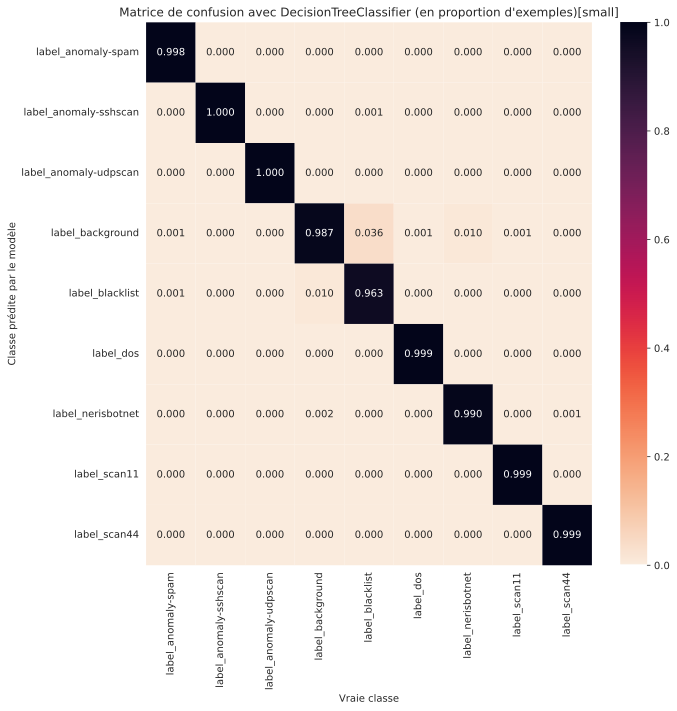

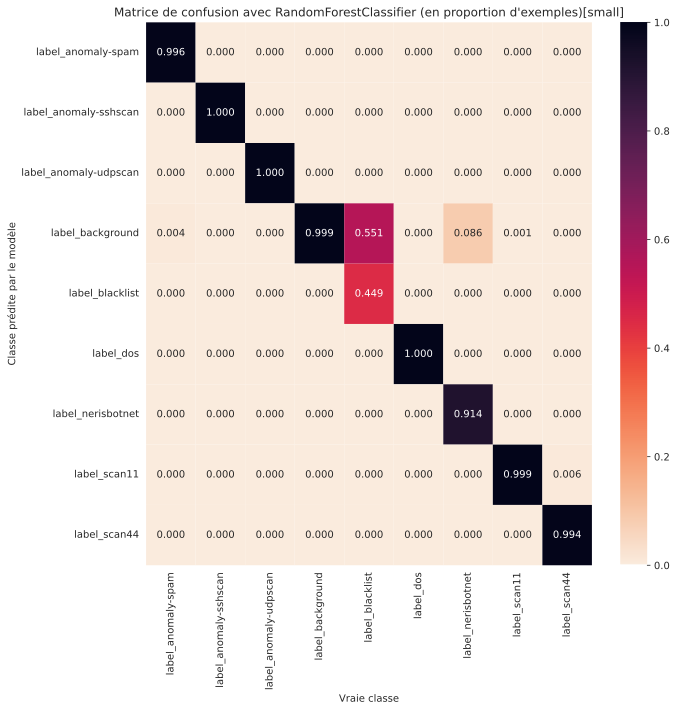

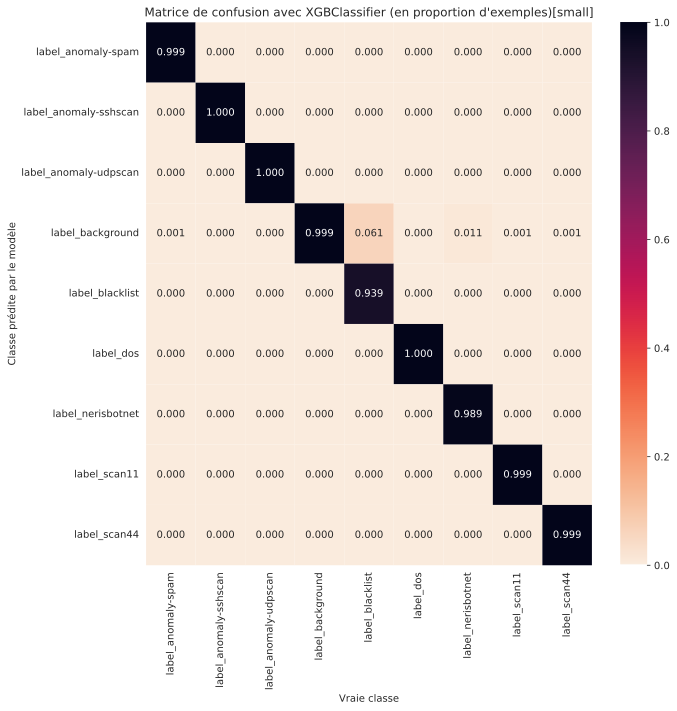

,accuracy_score,f1_score,roc_auc_score,precision_score,recall_score
model_name,,,,,
DecisionTreeClassifier,0.990417,0.990417,0.995670,0.990417,0.990417
RandomForestClassifier,0.959167,0.959167,0.959473,0.959167,0.959167
XGBClassifier,0.994931,0.994931,0.995219,0.994931,0.994931


In [69]:
performance_list = []
for model_name, model in model_dict.items():
    performance = evaluation(model_name, model, x_test, y_test)
    performance["model_name"] = model_name
    performance_list.append(performance)

pd.DataFrame(performance_list).set_index("model_name")

## Tester les modèles sur le jeu d'attaque avant l'attaque

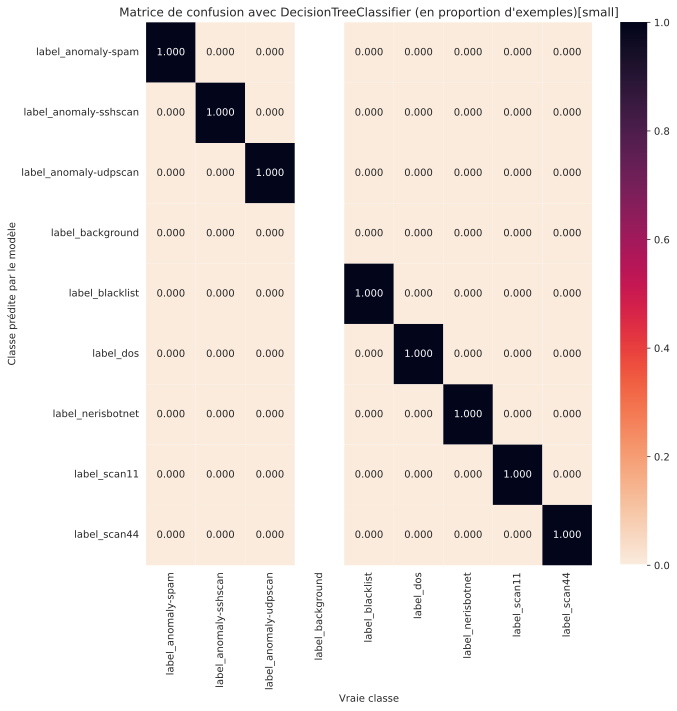

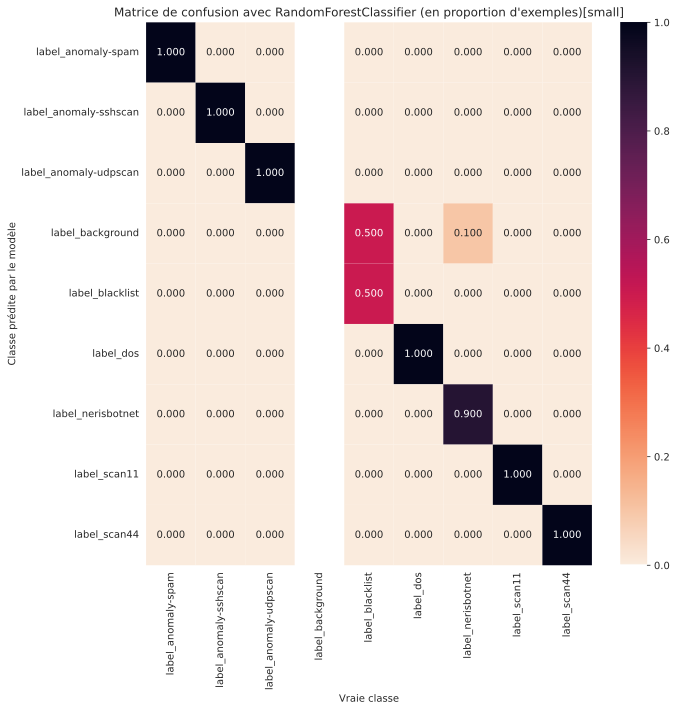

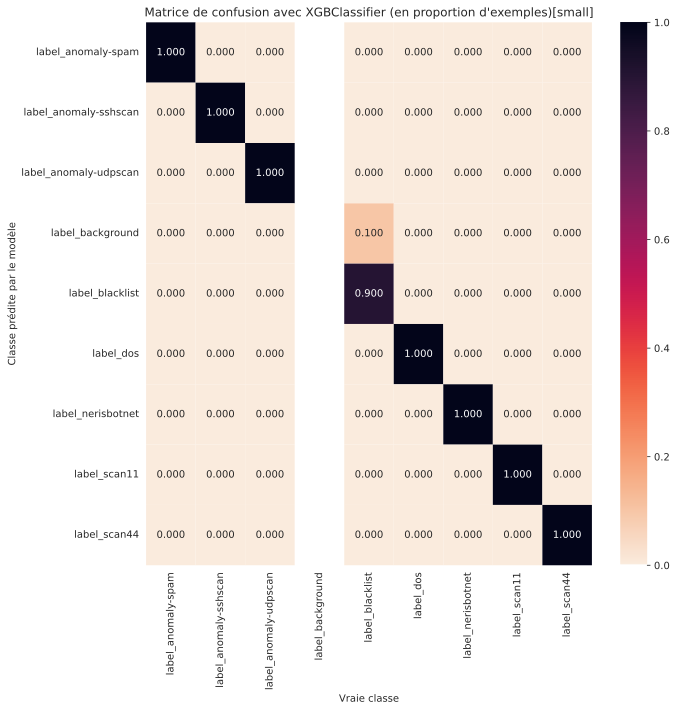

,accuracy_score,f1_score,precision_score,recall_score
model_name,,,,
DecisionTreeClassifier,1.0000,1.0000,1.0000,1.0000
RandomForestClassifier,0.9250,0.9250,0.9250,0.9250
XGBClassifier,0.9875,0.9875,0.9875,0.9875


In [70]:
performance_list = []
for model_name, model in model_dict.items():
    performance = evaluation(model_name, model, x_selected_attack, y_selected_attack, with_auroc=False)
    performance["model_name"] = model_name
    performance_list.append(performance)

pd.DataFrame(performance_list).set_index("model_name")

## Attaquer les modèles